# Decision tree for 0MA queries
## PostgreSQL, basic features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [4]:
file_path = 'results/features_times_POS_infos.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(med)             orig(med)  rewr(med)  \
0  STATS              001-014           orig  0.028890371322631836   0.057282   
1  STATS        001-014-augA1           orig   0.02893853187561035   0.041102   
2  STATS        001-014-augA2           orig  0.029188871383666992   0.163460   
3  STATS        001-014-augF1           orig   0.02954697608947754   0.059649   
4  STATS  001-014-augF1-augA1           orig  0.029439449310302734   0.039714   

   stage0(med)  stage1(med)  #relations  #conditions  #filters  ...  \
0     0.001469     0.055797           3            7         5  ...   
1     0.001567     0.037294           3            7         5  ...   
2     0.001431     0.162071           3            7         5  ...   
3     0.001516     0.057919           3            7         5  ...   
4     0.001500     0.037889           3            7         5  ...   

   min(branching factors)  max(branching factors)  mean(branching factors)  \
0                       2                       2                      2.0   
1                       1                       1                      1.0   
2                       1                       1                      1.0   
3                       2                       2                      2.0   
4                       1                       1                      1.0   

   median(branching factors)  q25(branching factors)  q75(branching factors)  \
0                        2.0                     2.0                     2.0   
1                        1.0                     1.0                     1.0   
2                        1.0                     1.0                     1.0   
3                        2.0                     2.0                     2.0   
4                        1.0                     1.0                     1.0   

   balancedness factor                          container counts list  \
0                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4                  NaN  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                               text  
0                     [2]  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1                  [1, 1]  SELECT MIN(c.id) FROM comments as c, votes as ...  
2                  [1, 1]  SELECT MIN(v.id) FROM comments as c, votes as ...  
3                     [2]  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4                  [1, 1]  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 28 columns]

In [5]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                    float64
stage0(med)                  float64
stage1(med)                  float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
container counts list         object
branching factors list        object
t

#### Delete those examples, where both methods gave a timeout

In [6]:
df[df["orig/rewr(med)"] == "-"].shape

(38, 28)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [7]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(2898, 28)

In [8]:
df[df["orig(med)"] == "TO"].shape

(256, 28)

In [9]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [10]:
df[df["rewr(med)"] == "TO"].shape

(0, 28)

In [11]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [12]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [13]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [14]:
X = df.iloc[:, 7:24]
X.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      2                      1   
2           3            7         5       2      2                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      2                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       1   
2                       1.0                    1.0                       1   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       1   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       1                      1.0                        1.0   
2                       1                      1.0                        1.0   
3                       2                      2.0                        2.0   
4                       1                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     1.0                     1.0  
2                     1.0                     1.0  
3                     2.0                     2.0  
4                     1.0                     1.0

#### Log-transformations

This basic features do not need log transformations.

In [15]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min   Max       Diff
#relations                 2.000000  11.0   9.000000
#conditions                2.000000  20.0  18.000000
#filters                   0.000000  16.0  16.000000
#joins                     1.000000  12.0  11.000000
depth                      1.000000   7.0   6.000000
min(container counts)      1.000000   1.0   0.000000
max(container counts)      2.000000   5.0   3.000000
mean(container counts)     1.047619   1.6   0.552381
q25(container counts)      1.000000   1.0   0.000000
median(container counts)   1.000000   1.0   0.000000
q75(container counts)      1.000000   1.5   0.500000
min(branching factors)     1.000000   6.0   5.000000
max(branching factors)     1.000000   6.0   5.000000
mean(branching factors)    1.000000   6.0   5.000000
median(branching factors)  1.000000   6.0   5.000000
q25(branching factors)     1.000000   6.0   5.000000
q75(branching factors)     1.000000   6.0   5.000000

In [16]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [17]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [18]:
y1.value_counts()

orig/rewr(med)
1    1509
0    1389
Name: count, dtype: int64

In [19]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1389
orig     1509
equal       -
dtype: object

In [20]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
rewr    1509
orig    1389
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [21]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [22]:
y1_test.value_counts()

orig/rewr(med)
0    146
1    144
Name: count, dtype: int64

In [23]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [24]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [25]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_6527/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_6527/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_6527/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1    1   10  100   TO
rewr    41  216  388  371  237  256
orig    99  615  505  117   48    0

In [26]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [27]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_6527/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_6527/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1   1  10  100  TO
rewr     4   25  38  31   25  21
orig    11   63  60  11    1   0

### Train a decision tree and observe the results on the test set

In [28]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [29]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.8482758620689655
0.8731343283582089
0.8125


array([[129,  17],
       [ 27, 117]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [30]:
test_set = df.loc[y1_test.index]

In [31]:
test_set["decision"] = y1_pred_dec_tree

In [32]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [33]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [34]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig        rewr          dec        true
sum     3195.494176  962.793773  1045.236409  847.172961
mean      11.018945    3.319979     3.604263    2.921286
median     0.001024    0.012908     0.001024    0.001024
std      100.000000   93.866337   100.000000   93.866337
min        0.227161    0.193454     0.146177    0.136947
max       27.562399   12.919541    14.848512   12.504520

#### Inspection of the misclassifications

In [35]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                 query orig/rewr(med)  \
1983           0           1   SNAP   google-tree01-augA4           rewr   
2729           0           1  HETIO  10-03-SpDaGpPW-augA4           rewr   
926            0           1  STATS   075-037-augF2-augA2           rewr   
1146           1           0  STATS   093-075-augF1-augA5           orig   
1112           0           1  STATS         091-035-augA1           rewr   
1114           0           1  STATS         091-035-augA3           rewr   
1486           1           0  STATS   121-097-augF1-augA1           orig   
912            1           0  STATS   074-072-augF2-augA2           orig   
2441           0           1  HETIO   3-03-CbGiGaD2-augA4           rewr   
1103           0           1  STATS   090-079-augF1-augA4           rewr   
861            1           0  STATS         071-080-augA2           orig   
1038           1           0  STATS   084-044-augF2-augA3           orig   
2542           0           1  HETIO          3-18-CuGuCtD           rewr   
2512           0           1  HETIO    3-13-CtDlAlD-augA5           rewr   
2424           0           1  HETIO    3-01-CbGbCtD-augA1           rewr   
981            1           0  STATS   080-119-augF1-augA1           orig   
1094           0           1  STATS         090-079-augA1           rewr   
2402           0           1  HETIO      2-01-CbGaD-augA4           rewr   
1115           0           1  STATS         091-035-augF1           rewr   
2386           0           1   LSQB              q1-augA2           rewr   
1206           0           1  STATS               098-124           rewr   
966            0           1  STATS         079-112-augF1           rewr   
1818           1           0  STATS   142-135-augF1-augA2           orig   
1776           1           0  STATS   139-034-augF1-augA3           orig   
1707           1           0  STATS   135-136-augF1-augA2           orig   
1525           0           1  STATS   123-047-augF2-augA4           rewr   
2668           0           1  HETIO   9-03-DaGrGpMF-augA6           rewr   
1515           0           1  STATS         123-047-augA4           rewr   
645            0           1  STATS         052-029-augF2           rewr   
2404           1           0  HETIO      2-02-CdGuD-augA1           orig   
915            1           0  STATS   074-072-augF2-augA5           orig   
904            0           1  STATS         074-072-augF1           rewr   
2152           0           1    JOB              2c-augA2           rewr   
7              1           0  STATS   001-014-augF2-augA1           orig   
927            0           1  STATS   075-037-augF2-augA3           rewr   
2686           0           1  HETIO   9-06-DaGiGpMF-augA3           rewr   
956            1           0  STATS   078-082-augF1-augA1           orig   
2748           0           1  HETIO   11-03-SpDlAdG-augA2           rewr   
980            1           0  STATS         080-119-augF1           orig   
1159           1           0  STATS         094-091-augF2           orig   
336            1           0  STATS   027-132-augF1-augA3           orig   
803            0           1  STATS   065-012-augF1-augA1           rewr   
863            1           0  STATS   071-080-augF1-augA1           orig   
1922           0           1   SNAP     dblp-tree01-augA4           rewr   

       orig(med)  rewr(med)  stage0(med)  stage1(med)  #relations  ...  \
1983  100.000000  15.696298     0.001486    15.694812           5  ...   
2729    0.417977   0.293499     0.002438     0.291168           7  ...   
926     0.228585   0.163952     0.001839     0.161965           4  ...   
1146    0.057462   0.248642     0.002784     0.245968           6  ...   
1112    0.237072   0.092944     0.001938     0.090987           4  ...   
1114    0.236353   0.126155     0.001703     0.124452           4  ...   
1486    0.054806   0.139683     0.001868     0.137745           4  

In [36]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


In [37]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/POS_0MA_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [38]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_6527/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_6527/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_6527/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

cut  0.01  0.1   1  10  100  TO
FP      5    7   5   0    0   0
FN      2   10  10   3    0   2

#### Statistical tests

In [39]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [40]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
2601           0           0  HETIO    6-01-BPpGeA-augF2           orig   
1713           1           1  STATS  135-136-augF2-augA3           rewr   
2179           0           0    JOB       2d-augF2-augA4           orig   
228            0           0  STATS        018-065-augF1           orig   
50             0           0  STATS        004-041-augF2           orig   

      orig(med)  rewr(med)  stage0(med)  stage1(med)  #relations  ...  \
2601   0.112187   1.100560     0.001874     1.098730           5  ...   
1713  22.324347   0.220428     0.002565     0.217541           5  ...   
2179   0.001258   3.558500     0.002054     3.556462           5  ...   
228    0.070599   0.213201     0.002773     0.210360           6  ...   
50     0.023926   0.055808     0.001844     0.053964           4  ...   

      mean(branching factors)  median(branching factors)  \
2601                 1.333333                        1.0   
1713                 2.000000                        2.0   
2179                 2.000000                        2.0   
228                  5.000000                        5.0   
50                   1.500000                        1.5   

      q25(branching factors)  q75(branching factors)  balancedness factor  \
2601                    1.00                    1.50             1.000000   
1713                    1.50                    2.50             1.000000   
2179                    2.00                    2.00             0.666667   
228                     5.00                    5.00             1.000000   
50                      1.25                    1.75             1.000000   

                                  container counts list  \
2601                              [1, 1, 1, 1, 1, 2, 3]   
1713  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2179  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
228   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
50    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

      branching factors list  \
2601               [1, 2, 1]   
1713                  [3, 1]   
2179                  [2, 2]   
228                      [5]   
50                    [2, 1]   

                                                   text  diff rewr-orig  \
2601  SELECT MIN(bp.name) FROM biological_process bp...        0.988373   
1713  SELECT MIN(b.id) FROM comments as c, posts as ...      -22.103920   
2179  SELECT MIN(mk.id) AS movie_title FROM company_...        3.557242   
228   SELECT MIN(c.Id) FROM comments as c, posts as ...        0.142602   
50    SELECT MIN(pl.Id) FROM postLinks as pl, posts ...        0.031883   

      pred(med)  
2601   0.112187  
1713   0.220428  
2179   0.001258  
228    0.070599  
50     0.023926  

[5 rows x 32 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [41]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 322.0
P-value: 1.0739345002403844e-20


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [42]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 6.255585581415181
P-value: 1.4227258520623015e-09


#### Important features using Gini importance

In [43]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters   #joins    depth  \
Importance    0.001408     0.140792  0.195375  0.09887  0.00732   

            min(container counts)  max(container counts)  \
Importance                    0.0               0.048353   

            mean(container counts)  q25(container counts)  \
Importance                0.462304                    0.0   

            median(container counts)  q75(container counts)  \
Importance                       0.0                    0.0   

            min(branching factors)  max(branching factors)  \
Importance                0.001394                0.015979   

            mean(branching factors)  median(branching factors)  \
Importance                 0.003756                   0.001037   

            q25(branching factors)  q75(branching factors)  
Importance                0.002788                0.020623

In [44]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
mean(container counts)       0.462304
#filters                     0.195375
#conditions                  0.140792
#joins                       0.098870
max(container counts)        0.048353
q75(branching factors)       0.020623
max(branching factors)       0.015979
depth                        0.007320
mean(branching factors)      0.003756
q25(branching factors)       0.002788
#relations                   0.001408
min(branching factors)       0.001394
median(branching factors)    0.001037
q75(container counts)        0.000000
median(container counts)     0.000000
min(container counts)        0.000000
q25(container counts)        0.000000

#### Visualization of the decision tree

In [45]:
clf.tree_.max_depth

16

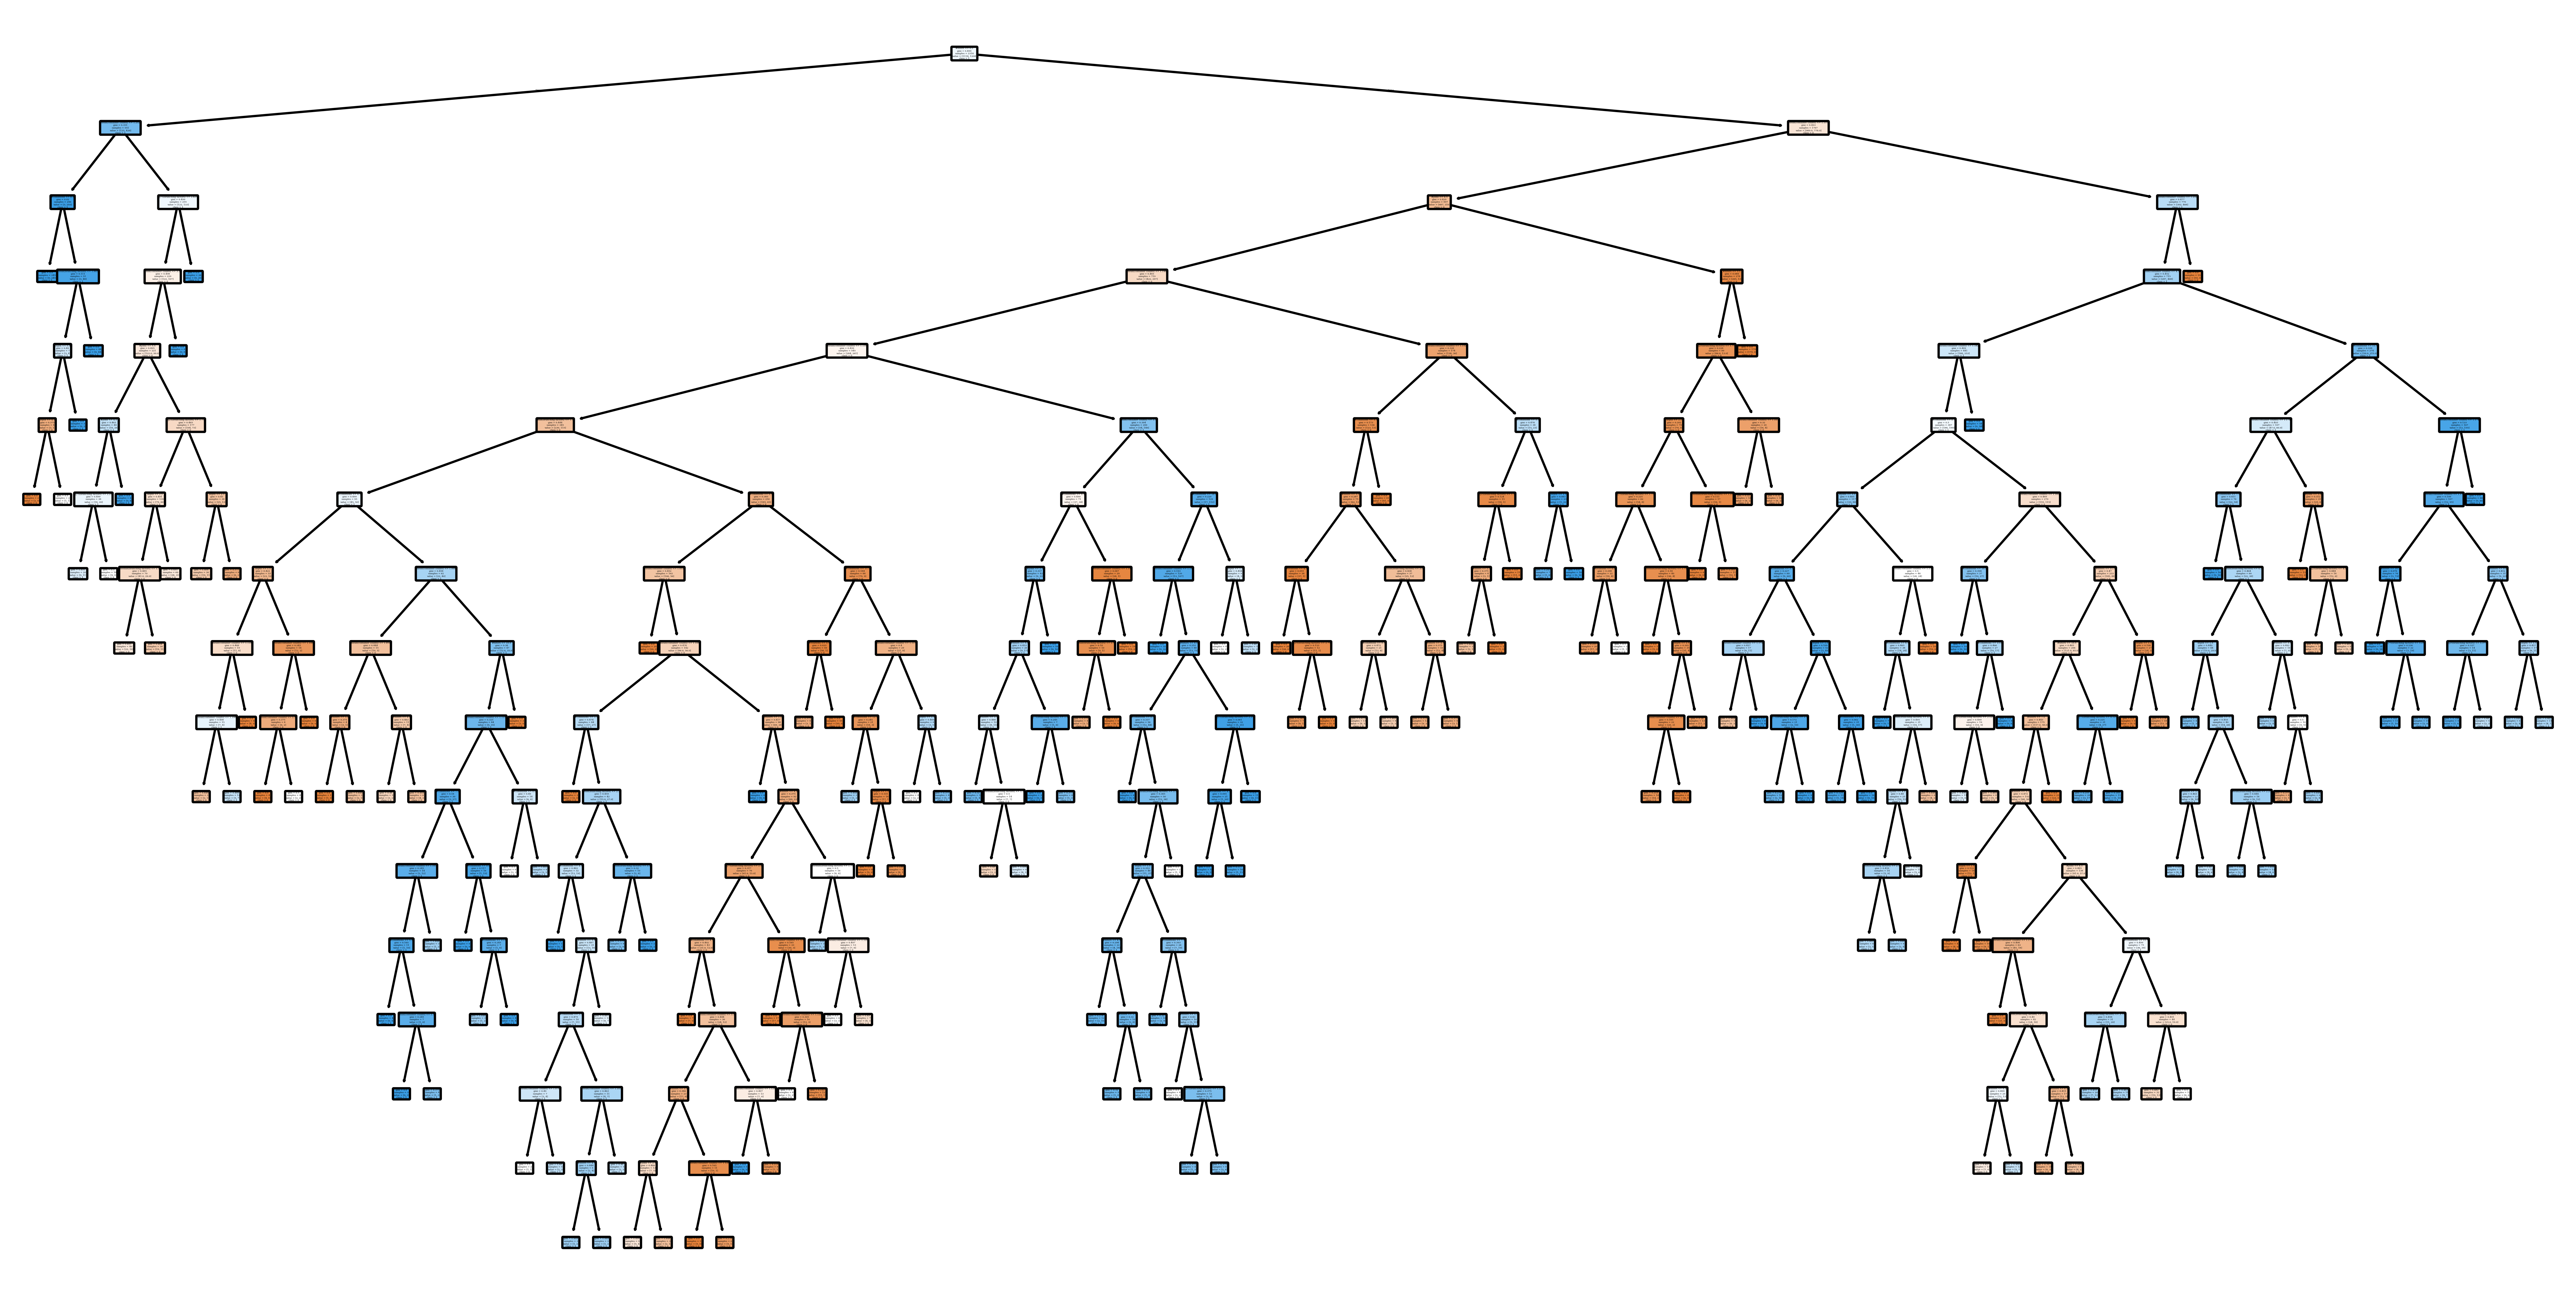

In [46]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/POS_0MA_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

In [47]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/POS_0MA_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_6527/325003353.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6527/325003353.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6527/325003353.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/POS_0MA_runtimes_color.png') 
plt.show()


/tmp/ipykernel_6527/375517664.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6527/375517664.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_6527/375517664.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

In [49]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/POS_0MA_runtimes.png')
plt.show()